In [1]:
import Data_generator_multiple as dg
import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torch import optim
import math, random
import matplotlib.pyplot as plt
import Plot_More_Assets as PMA
import Func_Two_Assets as FTA
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

e:\Science\Miniconda\envs\cost\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# initialize seed, mu, sigma, S0, paths, steps, T
# Clear pytorch cache
torch.cuda.empty_cache()

# Set model parameters
seed_train = 36
seed_test = 43
num_stocks = 2
total_path = 23000
seq_length = 120
T=10
n_partition = 1
npaths = int(total_path/n_partition)
s0=np.array([1,1])
mu = np.array([0.12, 0.12])
mu = np.array([0.0362, 0.0036])
k = 0.075
cov = np.array([[0.4-k, k],[k, 0.4-k]])
cov = np.array([[0.0225, 0.00132],[0.00132, 0.0016]])
trade_cost = np.array([[0.01,0.01]])
trade_cost = np.array([[0.0001,0.005],[0.0001,0.025],[0.0001,0.05]])

utility_gamma = 3.000

# Set Simulation parameters: Notice that initial_rotate_matrix should be well guessed
n_epochs = 90
learning_rate = 0.01
#initial_rotate_matrix = torch.tensor([[1.05,-0.05], [-0.05,1.05]])
is_importance = False
is_batch = False

In [4]:
ESR_RNN_vec = np.zeros((trade_cost.shape[0]))
CI_upper_vec = np.zeros((trade_cost.shape[0]))
CI_lower_vec = np.zeros((trade_cost.shape[0]))
ESR_theo_vec = np.zeros((trade_cost.shape[0]))
ESR_opt_vec = np.zeros((trade_cost.shape[0]))

e:\Documents\OneDrive - Dublin City University\TradingCost\Func_Two_Assets.py:49: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta_tensor = torch.tensor(delta, dtype = torch.float).to(device)


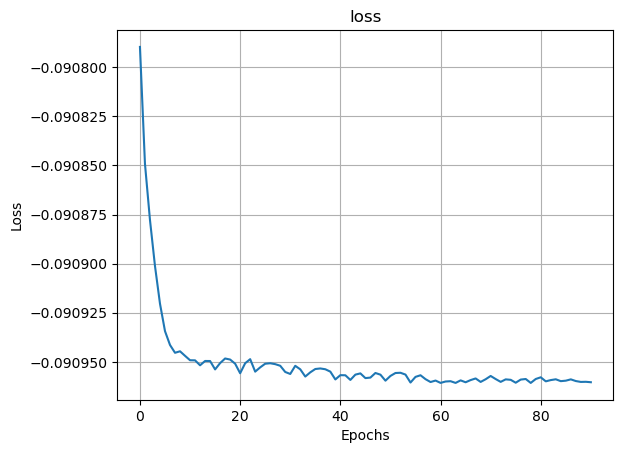

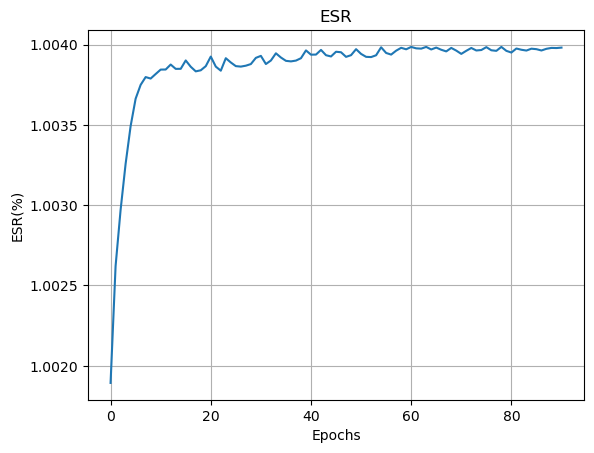

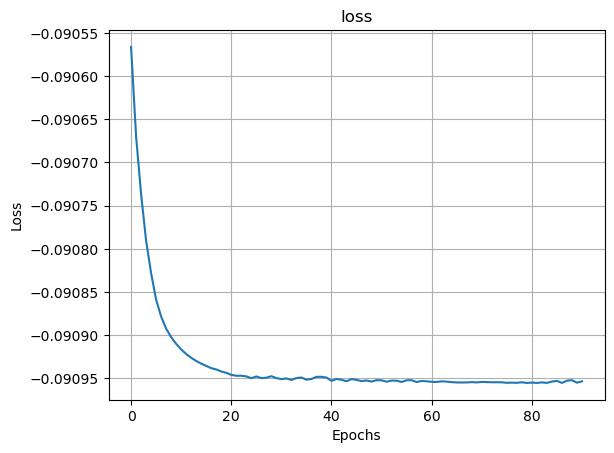

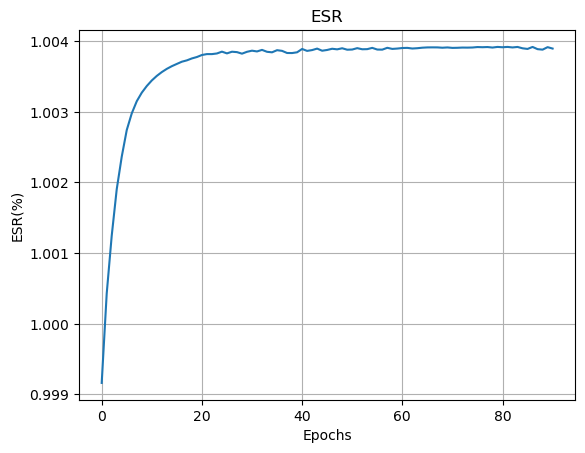

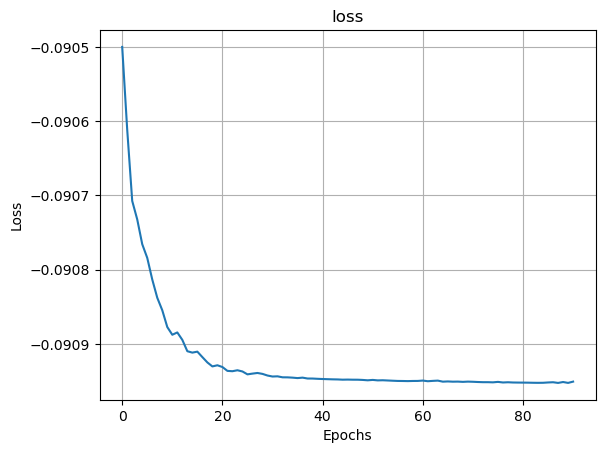

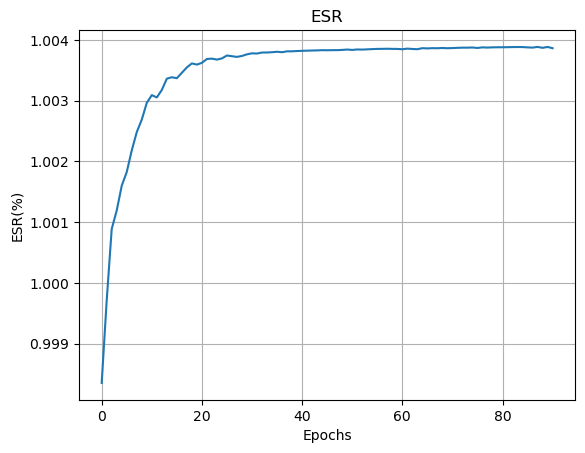

In [5]:
for i in range(trade_cost.shape[0]):
    #set up training data and model
    returns, strategy, cost, Merton_opt, Merton_opt_tensor, delta_tensor = FTA.make_portfolio\
        (i,seed_train,mu,cov,s0,total_path,num_stocks,seq_length,T,trade_cost,utility_gamma)
    returns, scaler = FTA.importance_sampling\
        (is_importance,seed_train,mu,cov,s0,num_stocks, total_path,seq_length,utility_gamma,T)
    
    initial_rotate_matrix = FTA.initial_rotate_matrix(cov,delta_tensor,num_stocks)
    
    model, criterion, optimizer = FTA.make_model2\
        (1, 1, 1, num_stocks, npaths, seq_length, delta_tensor, initial_rotate_matrix, utility_gamma, learning_rate)
    model,losses = FTA.train_model\
        (strategy, strategy[:,0,0], returns, cost, scaler, model, criterion, optimizer,n_epochs,is_batch,n_partition,npaths,utility_gamma,T)
    model_state_dict = model.state_dict()
    # set up testing data
    returns, strategy, cost, Merton_opt, Merton_opt_tensor, delta_tensor = FTA.make_portfolio\
        (i,seed_test,mu,cov,s0,total_path,num_stocks,seq_length,T,trade_cost,utility_gamma)

    # theoretical ESR without cost
    ESR_opt = np.matmul(mu.T,np.matmul(np.linalg.inv(cov),mu))/2/utility_gamma
    # ESRs with costs
    ESR_etf, ESR_NTR, ESR_RNN, CI = FTA.ESR2\
        (1, 1, 1,num_stocks, seq_length, npaths,model_state_dict,  strategy, returns, cost, utility_gamma, T, scaler = 1)
    ESR_special = FTA.ESR_special(mu,cov,utility_gamma,trade_cost[i])
    ESR_RNN_vec[i] = ESR_RNN[0]
    CI_upper_vec[i] = CI[0]
    CI_lower_vec[i] = CI[1]
    ESR_theo_vec[i] = ESR_special
    ESR_opt_vec[i] = ESR_opt

    #delete used data
    del optimizer
    del returns
    torch.cuda.empty_cache()
    if i != trade_cost.shape[0]-1:
        del model
    

e:\Documents\OneDrive - Dublin City University\TradingCost\Plot_More_Assets.py:49: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  Cmean, = ax.plot(x, simulated, 'k--',color='blue')


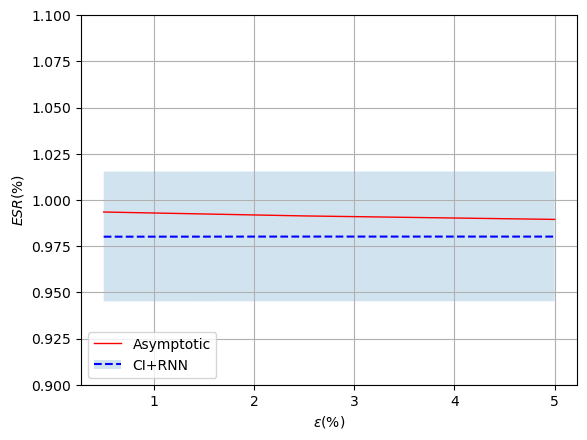

In [6]:
PMA.plot_esr(np.array(trade_cost[:,1]),ESR_theo_vec,CI_lower_vec,CI_upper_vec,ESR_RNN_vec)

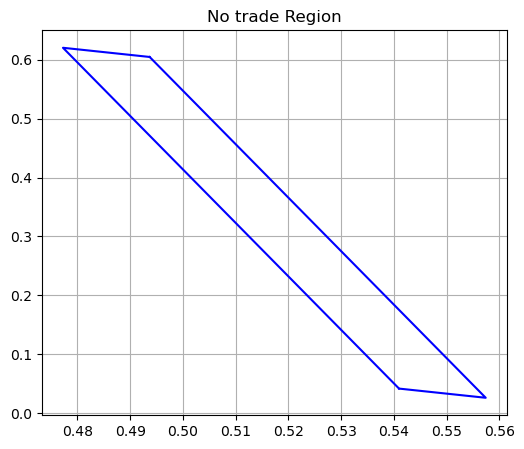

In [7]:
PMA.plot_ntr_two2(model, Merton_opt, x_range=None, y_range=None)

In [9]:
model_state_dict

OrderedDict([('rnn.input_param.weight',
              tensor([[0.],
                      [0.]], device='cuda:0')),
             ('rnn.input_param.bias',
              tensor([ 0.0489, -0.2788], device='cuda:0')),
             ('rnn.hidden_param.weight',
              tensor([[1.],
                      [1.]], device='cuda:0')),
             ('rnn.hidden_param.bias',
              tensor([0.0146, 0.1062], device='cuda:0')),
             ('rnn.fc1_param.weight',
              tensor([[-1.],
                      [-1.]], device='cuda:0')),
             ('rnn.fc1_param.bias', tensor([0.0292, 0.2123], device='cuda:0')),
             ('rnn.fc2_param.weight',
              tensor([[-1.],
                      [-1.]], device='cuda:0')),
             ('rnn.fc2_param.bias', tensor([0.3513, 0.2927], device='cuda:0')),
             ('rnn.rotate_param.weight',
              tensor([[-0.0236,  0.0401],
                      [ 0.2815, -0.2971]], device='cuda:0')),
             ('out.weight', tensor(